## Frameworks

In [1]:
import gurobipy as gp
from gurobipy import GRB
import json
import numpy as np
import pandas as pd
import time
import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objects as go
from scipy.interpolate import griddata

## 1) Load Instance

In [2]:
start = time.time()

In [3]:
#path="instances/test.json"
#path="instances/toy_instance.json"
path="instances/medium_instance.json"
#path="instances/large_instance.json"

# JSON file
f = open (path, "r")
  
# Reading from file
data = json.loads(f.read())

In [4]:
# Gains
Gm=[]
for job in data["jobs"]:
    Gm.append(job['gain'])
Gm=np.array(Gm)

# Penalty
Pm=[]
for job in data["jobs"]:
    Pm.append(job['daily_penalty'])
Pm=np.array(Pm)

# Due Date
Dm=[]
for job in data["jobs"]:
    Dm.append(job['due_date'])
Dm=np.array(Dm)

# Penalty per day
Penalty=[]
for job in data["jobs"]:
    job_penalty=[]
    p=0
    for t in range(data["horizon"]):
        if (t>job["due_date"]-1):
            p+=job["daily_penalty"]
        job_penalty.append(p)
    Penalty.append(job_penalty)
Penalty=np.array(Penalty)

# Profit per day
Profit=[]
for job in data["jobs"]:
    job_benef=[]
    p=job['gain']
    for t in range(data["horizon"]):
        if (t>job["due_date"]-1):
            p-=job["daily_penalty"]
        job_benef.append(p)
    Profit.append(job_benef)
Profit=np.array(Profit)

# Vacations per day and per employee
Vacations=[]
for e in data["staff"]:
    e_planning=[]
    v=e['vacations']
    for t in range(data["horizon"]):
        if (t+1 in v):
            e_planning.append(1)
        else:
            e_planning.append(0)
    Vacations.append(e_planning)
Vacations=np.array(Vacations)

# Employee qualifications
Qualifications_staff=[]
for staff in data["staff"]:
    list_staff=[]
    for q in data["qualifications"]:
        if(q in staff["qualifications"]):
            list_staff.append(1)
        else:
            list_staff.append(0)
    Qualifications_staff.append(list_staff)
Qualifications_staff = np.array(Qualifications_staff)

# Jobs Qualifications
Qualifications_job=[]
for job in data["jobs"]:
    #working_days_per_qualification
    list_job=[]
    for q in data["qualifications"]:
        try:
            val=job['working_days_per_qualification'][q]
        except:
            val=0
        list_job.append(val)
    Qualifications_job.append(list_job)
Qualifications_job=np.array(Qualifications_job)

## 2) Model

In [5]:
###
# MODEL
model = gp.Model()

horizon=data["horizon"]
qualifs=len(data["qualifications"])
projects=len(data["jobs"])
staffs=len(data["staff"])

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-29


## 3) Variables

In [6]:
###
# VARIABLES

# Planning 
Planning = model.addMVar(
                        shape=(staffs,horizon,projects,qualifs),
                        vtype=GRB.BINARY,
                        name="Planning"
                        )

# Delay 
Delay_project = model.addVars(
                                projects,
                                lb=0,
                                ub=horizon,
                                vtype=GRB.INTEGER,
                                name="Delay_project"
                            ) 

# End Date 
End_project = model.addVars(
                                projects,
                                vtype=GRB.INTEGER,
                                name="End_project"
                            ) 

# Realisation Boolean
Realisation = model.addVars(
                                projects,
                                vtype=GRB.BINARY,
                                name="Realisation"
                            )

# Begin 

Begin_project = model.addVars(
                                projects,
                                vtype=GRB.INTEGER,
                                name="End_project"
                            ) 

Lenght_project = model.addVars(
                                projects, 
                                vtype=GRB.INTEGER, 
                                name="Lenght_project")

Max_duration_lenght = model.addVar(
                                    vtype = GRB.INTEGER,
                                    name = "Max_duration_lenght")


## 4) Constraints

In [7]:
###
# CONSTRAINTS

#1 Uicity of affectation 
model.addConstrs(
    (gp.quicksum(gp.quicksum(Planning[staff][t]))<= 1
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
    ),
    name="staff_qualif_unicity"
) 

#2 Vacations
model.addConstrs(
    (Planning[staff][t][job][qualif]<=1-Vacations[staff][t] 
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
        for job in range(len(data["jobs"]))
        for qualif in range(len(data["qualifications"]))
    ),
    name="Vacations_constraint"
) 


#3 Qualification staff
model.addConstrs(
    (Planning[staff][t][job][qualif]<=Qualifications_staff[staff][qualif]
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
        for job in range(len(data["jobs"]))
        for qualif in range(len(data["qualifications"]))
    ),
    name="Qualif_staff_constraint"
) 


# Definition d'une liste de la somme des temps de qualifs par projet
Max_temp_qualif_job=[]
for job in range(len(data["jobs"])):
    l_job=[]
    for qualif in range(len(data["qualifications"])):
        temp_qualif_job=0
        for t in range(data["horizon"]):
            for staff in range(len(data["staff"])):
                temp_qualif_job+=Planning[staff][t][job][qualif]
        l_job.append(temp_qualif_job)
    Max_temp_qualif_job.append(l_job)
Max_temp_qualif_job


#4 Couverture des qualifs => realisation
model.addConstrs(
        (Max_temp_qualif_job[job][qualif] >= Realisation[job] *  Qualifications_job[job][qualif]
            for job in range(len(data["jobs"]))
            for qualif in range(len(data["qualifications"]))
        ), name = "cover_qualif"
)

#5 Unicity realisation
model.addConstrs(
    (Max_temp_qualif_job[job][qualif] <= Qualifications_job[job][qualif]
            for job in range(len(data["jobs"]))
            for qualif in range(len(data["qualifications"]))
), name = "project_done_once")

#6 end project 
model.addConstrs(
   (Planning[staff][t][job][qualif] * t+1 <= End_project[job]
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
        for job in range(len(data["jobs"]))
        for qualif in range(len(data["qualifications"]))
), name = "end_project_date")

#7 Delay 
model.addConstrs(
    (End_project[job] - Dm[job] <= Delay_project[job]
       for job in range(len(data["jobs"]))
    ), name="delay_project"
)



Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>}

# Max or Epsilon

In [8]:
epsilon_constraint = False

## 5) Objectives

In [9]:
model.ModelSense = GRB.MAXIMIZE

### Z1: Maximize Profit

In [10]:
# ici on suppose que si le projet n'est pas réalisé alors il n'est pas commencé donc pas de delay ?
# à vérifier ! (ajouter constraint #9 ?)
if epsilon_constraint == False:
    Z1 = gp.quicksum((Realisation.values()*Gm)-(Pm*Delay_project.values()))
    model.setObjectiveN(
        Z1, 
        index=0, 
        priority=2, 
        name='Profit')

### Z2: Minimize Number of Projects per Employee

In [11]:
# Jobs done by one staff
jobs_staffeur = model.addMVar(shape=(staffs,projects),vtype=GRB.BINARY,name="jobs_staffeur")

for staff in range(staffs):
    for job in range(projects):
        val=[]
        for t in range(horizon):
            for qualif in range(qualifs):
                val.append(Planning[staff][t][job][qualif])
        model.addConstr((jobs_staffeur[staff][job] == gp.max_(val)))

# Sum of all jobs for one staff
sum_staff_jobs = model.addVars(staffs,vtype=GRB.INTEGER, name="sum_staff_jobs")         

for staff in range(staffs):
    model.addConstr((sum_staff_jobs[staff]==gp.quicksum(jobs_staffeur[staff])))


In [12]:
if epsilon_constraint == False:
    for staff in range(staffs):
        model.setObjectiveN(sum_staff_jobs[staff], 
                            index=1+staff, 
                            priority=1, 
                            weight=-1,
                           name='Staff_Assign')  #weight = -1 to minimize


### Z3: Minimize Realisation Time

In [13]:
#on ne peut commencer un projet avant le jour 1
for job in range(projects):
    model.addConstr(Begin_project[job] >= 1)

## création d'une liste pour chaque jour met soit 0 si le projet n'est pas travaillé soit le jour en question
## l'idée est d'ensuite récupérer le min de cette liste
for job in range(projects):
    for t in range(horizon):
        for staff in range(staffs):
            for qualif in range(qualifs):
                model.addConstr(Begin_project[job] <= Planning[staff][t][job][qualif]*(t+1) +horizon*(1-Planning[staff][t][job][qualif]))

#lenght of a project
for job in range(projects):
    model.addConstr(End_project[job] + 1 - Begin_project[job] <= Lenght_project[job])

#max lenght of a project
for job in range(projects):
    model.addConstr(Lenght_project[job] <= Max_duration_lenght)

In [14]:
if epsilon_constraint == False:
    model.setObjectiveN(-Max_duration_lenght,
                        index = 2,
                        priority = 0,
                        name='Max_Duration')

## Optimize

In [15]:
if epsilon_constraint == False:
    model.optimize()
#My Docker : Intel(R) Xeon(R) CPU E5-2640 v4 @ 2.40GHz
#Daniel :    Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 66475 rows, 16656 columns and 147234 nonzeros
Model fingerprint: 0x0c5c7d27
Model has 75 general constraints
Variable types: 0 continuous, 16656 integer (16590 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 7e+01]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 6 objectives (3 combined) ...
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 63812 rows and 15240 columns
Presolve time: 0.10s
Presolved: 2663 rows and 1416 columns

  1599   483  -16.74435   11  225  -18.00000  -14.41736  19.9%   178   10s
  3352   741  -16.09512   16  276  -18.00000  -15.03339  16.5%   166   15s
  5180   609  -16.66018   14  255  -18.00000  -15.58796  13.4%   165   20s

Cutting planes:
  Gomory: 25
  Cover: 45
  Clique: 6
  MIR: 69
  StrongCG: 14
  GUB cover: 4
  Inf proof: 1
  Zero half: 18
  Mod-K: 2
  RLT: 88
  Relax-and-lift: 215

Explored 7057 nodes (1121517 simplex iterations) in 23.96 seconds (35.53 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: -18 -20 -23 -24 
No other solutions better than -18

Optimal solution found (tolerance 1.00e-04)
Best objective -1.800000000000e+01, best bound -1.800000000000e+01, gap 0.0000%
---------------------------------------------------------------------------

Multi-objectives: optimize objective 3 () ...
---------------------------------------------------------------------------


Loaded user MIP start with objective -22

Presolve removed 15 rows and 15 col

 36121 15749   -6.00000   38  180  -12.00000   -4.00000  66.7%   576 1130s
 37333 15808   -4.00000   36  258  -12.00000   -4.00000  66.7%   581 1173s
 38379 15850   -4.00000   44  236  -12.00000   -4.00000  66.7%   588 1217s
 39552 16102 infeasible   31       -12.00000   -4.00000  66.7%   592 1262s
 40691 16142 infeasible   55       -12.00000   -4.00000  66.7%   596 1304s
 41695 16250   -5.00000   53  185  -12.00000   -4.00000  66.7%   602 1348s
 42853 16462 infeasible   41       -12.00000   -4.00000  66.7%   606 1401s
 44053 16527 infeasible   40       -12.00000   -4.00000  66.7%   611 1444s
 44710 16742     cutoff   36       -12.00000   -4.00000  66.7%   613 1479s
 45594 16973   -5.00000   45  237  -12.00000   -4.00000  66.7%   616 1529s
 46848 17157 infeasible   40       -12.00000   -4.00000  66.7%   621 1576s
 47925 17483 infeasible   46       -12.00000   -4.00000  66.7%   625 1624s
 49154 17972   -5.00000   30  337  -12.00000   -4.00000  66.7%   628 1676s
 50660 18346   -5.00000  

 117030 10737 infeasible   52       -12.00000   -8.00000  33.3%   650 4086s
 117674 10493   -8.00000   49  177  -12.00000   -8.00000  33.3%   651 4105s
 118609 10152   -8.02469   61  185  -12.00000   -8.00000  33.3%   650 4122s
 119487  9714  -10.00000   49  324  -12.00000   -8.00000  33.3%   650 4137s
 120530  9086 infeasible   50       -12.00000   -8.00000  33.3%   648 4152s
 121890  8191 infeasible   48       -12.00000   -9.00000  25.0%   645 4177s
 122907  7628   -9.00000   56  233  -12.00000   -9.00000  25.0%   645 4201s
 124436  7053 infeasible   54       -12.00000   -9.00000  25.0%   644 4221s
 125621  6505 infeasible   66       -12.00000   -9.00000  25.0%   643 4237s
 126080  6180 infeasible   53       -12.00000   -9.00000  25.0%   644 4252s
 126656  5802   -9.00000   47  189  -12.00000   -9.00000  25.0%   644 4266s
 127497  5087   -9.00000   51  201  -12.00000   -9.00000  25.0%   643 4280s
 128623  4178 infeasible   58       -12.00000  -10.00000  16.7%   641 4304s
 130226  327

## 6) Optimize with epsilon

In [47]:
if epsilon_constraint:
    epsilon_2nd_cst =  np.arange(projects, 0, -1)
    epsilon_3rd_cst =  np.arange(horizon, 0, -1)
    pareto_points = []

    for job in tqdm.tqdm(epsilon_2nd_cst):
        for t in epsilon_3rd_cst:
            
            for staff in range(staffs):
                model.addConstr( sum_staff_jobs[staff] <= job , name = f"max_switch_{job}_{staff}")

            model.addConstr( Max_duration_lenght <= t , name = "max_len")
            model.addConstr( Max_duration_lenght >= t , name = "max_len2")
            
            Z1 = gp.quicksum((Realisation.values()*Gm)-(Pm*Delay_project.values()))
            model.setObjective(
                Z1,
                GRB.MAXIMIZE
            )
            
            model.params.outputflag = 0
            model.optimize()
            for staff in range(staffs):
                model.remove((model.getConstrByName(f"max_switch_{job}_{staff}")))
                
            model.remove((model.getConstrByName("max_len")))
            model.remove((model.getConstrByName("max_len2")))

            Z1 = 0
            sum_assignation=0
            moyenne_assignation=0
            for staff in range(staffs):
                sum_assignation+=sum_staff_jobs[staff].x
        
            moyenne_assignation=sum_assignation/len(sum_staff_jobs)
            
            pareto_points.append((model.objVal, round(moyenne_assignation,2), Max_duration_lenght.X))


In [48]:
if epsilon_constraint:
    Profit = [i[0] for i in pareto_points]
    Assignation = [i[1] for i in pareto_points]
    Duration = [i[2] for i in pareto_points]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surf=ax.plot_trisurf(Assignation, Duration, Profit, cmap=cm.jet, linewidth=0.1)

    ax.set_xlabel('Moyenne Assignation')
    ax.set_ylabel('Max duration')
    ax.set_zlabel('Profit')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

In [49]:
if epsilon_constraint:
    x = Assignation
    y = Duration
    z = Profit

    xi = np.linspace(min(x), max(x), 100)
    yi = np.linspace(min(y), max(y), 100)

    X,Y = np.meshgrid(xi,yi)

    Z = griddata((x,y),z,(X,Y), method='cubic')

    fig = go.Figure(go.Surface(x=xi,y=yi,z=Z,surfacecolor=Z, colorscale='jet'))
    fig.update_layout(scene=dict(xaxis_title='Moyenne Assignation',
                                 yaxis_title='Max duration',
                                 zaxis_title='Profit'))
    fig.show()

## 7) Results

In [50]:
end = time.time()
print("Time taken: ", round(end - start,2), "seconds || ",round((end - start)/60,2), "minutes" )
# instance | time | profit, moyenne_assignation, Max_duration_lenght
# toy :  3 s ||  65, 2, 3
# medium : 76.94 minutes ||  413, 4.4, 12
#large : 3,7 min

Time taken:  44643.94 seconds ||  744.07 minutes


### Objectives

In [51]:
# Z1
print("Z1: Maximize Profit\n")
print("Solution || Best ")
print(" ",model.objVal,"  || ",Gm.sum())
print("\nDetails: Gain - Delay * Daily Penalty\n")
for job in range(projects):
    if(int(Realisation[job].x)==1):
        print(data["jobs"][job]["name"],":",data["jobs"][job]["gain"],"-",int(Delay_project[job].x),"*",data["jobs"][job]["daily_penalty"])
    else:
        print(data["jobs"][job]["name"],": Not Done")
print("------------")
print("Total =",model.objVal)


Z1: Maximize Profit

Solution || Best 
  413.0   ||  510

Details: Gain - Delay * Daily Penalty

Job1 : 15 - 1 * 3
Job2 : Not Done
Job3 : 30 - 0 * 3
Job4 : 30 - 0 * 3
Job5 : 70 - 0 * 3
Job6 : 40 - 0 * 3
Job7 : 20 - 2 * 3
Job8 : Not Done
Job9 : 25 - 1 * 3
Job10 : Not Done
Job11 : Not Done
Job12 : 45 - 0 * 3
Job13 : 40 - 0 * 3
Job14 : 60 - 0 * 3
Job15 : 50 - 0 * 3
------------
Total = 413.0


In [52]:
# Z2
print("Z2: Minimize Number of Projects per Employee\n")
print("Staff || Job(s) ||  Name")
for i in range(len(data["staff"])):
    print(" ",i,"  ||  ",int(sum_staff_jobs[i].x),"   || ",data["staff"][i]["name"])

Z2: Minimize Number of Projects per Employee

Staff || Job(s) ||  Name
  0   ||   4    ||  Olivia
  1   ||   4    ||  Liam
  2   ||   5    ||  Emma
  3   ||   4    ||  Noah
  4   ||   5    ||  Amelia


In [53]:
# Z3
print("Z3: Minimize Realisation Time\n")
print("  Job   || Begin ||  End  || Delta")
for i in range(len(data["jobs"])):
    print("  ",i+1,"   || ",int(Begin_project[i].x),"   ||  ",int(End_project[i].x),"  || ",int(End_project[i].x-Begin_project[i].x))  

Z3: Minimize Realisation Time

  Job   || Begin ||  End  || Delta
   1    ||  14    ||   21   ||  7
   2    ||  7    ||   16   ||  9
   3    ||  3    ||   12   ||  9
   4    ||  7    ||   18   ||  11
   5    ||  1    ||   10   ||  9
   6    ||  7    ||   16   ||  9
   7    ||  11    ||   22   ||  11
   8    ||  22    ||   22   ||  0
   9    ||  10    ||   19   ||  9
   10    ||  5    ||   16   ||  11
   11    ||  1    ||   1   ||  0
   12    ||  1    ||   12   ||  11
   13    ||  1    ||   12   ||  11
   14    ||  1    ||   12   ||  11
   15    ||  5    ||   16   ||  11


### Constraints

In [54]:
#Couverture qualif
print("- Couverture Qualifications -\n")
for job in range(len(data["jobs"])):
    print(data["jobs"][job]["name"],int(Realisation[job].x)==1)
    for qualif in range(qualifs):
        val=0
        for t in range(horizon):
            for staff in range(staffs):
                val+=int(Planning[staff][t][job][qualif].x)
        print(" .",data["qualifications"][qualif],val)
    print("Expected",Qualifications_job[job])
    print("---")

- Couverture Qualifications -

Job1 True
 . F 0
 . G 0
 . A 4
 . D 0
 . J 0
 . C 0
 . H 0
 . E 0
 . B 4
 . I 0
Expected [0 0 4 0 0 0 0 0 4 0]
---
Job2 False
 . F 0
 . G 0
 . A 0
 . D 0
 . J 0
 . C 0
 . H 0
 . E 0
 . B 0
 . I 0
Expected [0 0 4 4 0 1 0 0 2 0]
---
Job3 True
 . F 0
 . G 0
 . A 4
 . D 0
 . J 0
 . C 1
 . H 0
 . E 0
 . B 0
 . I 0
Expected [0 0 4 0 0 1 0 0 0 0]
---
Job4 True
 . F 0
 . G 0
 . A 6
 . D 0
 . J 0
 . C 0
 . H 0
 . E 0
 . B 0
 . I 0
Expected [0 0 6 0 0 0 0 0 0 0]
---
Job5 True
 . F 0
 . G 0
 . A 0
 . D 8
 . J 0
 . C 4
 . H 0
 . E 0
 . B 3
 . I 0
Expected [0 0 0 8 0 4 0 0 3 0]
---
Job6 True
 . F 0
 . G 0
 . A 0
 . D 4
 . J 0
 . C 0
 . H 0
 . E 5
 . B 0
 . I 0
Expected [0 0 0 4 0 0 0 5 0 0]
---
Job7 True
 . F 1
 . G 0
 . A 0
 . D 5
 . J 0
 . C 0
 . H 0
 . E 5
 . B 0
 . I 0
Expected [1 0 0 5 0 0 0 5 0 0]
---
Job8 False
 . F 0
 . G 0
 . A 0
 . D 0
 . J 0
 . C 0
 . H 0
 . E 0
 . B 0
 . I 0
Expected [6 0 0 0 0 0 0 3 0 0]
---
Job9 True
 . F 0
 . G 3
 . A 0
 . D 0
 . J 0
 .

In [55]:
# Due dates
print("- Due Dates -\n")
print("Project || Expected || End || Delay")
for i in range(len(data["jobs"])):
    print("  ",i+1,"   ||    ",data["jobs"][i]["due_date"],"   || ",int(End_project[i].x)," || ",int(Delay_project[i].x))

- Due Dates -

Project || Expected || End || Delay
   1    ||     20    ||  21  ||  1
   2    ||     16    ||  16  ||  0
   3    ||     12    ||  12  ||  0
   4    ||     18    ||  18  ||  0
   5    ||     10    ||  10  ||  0
   6    ||     16    ||  16  ||  0
   7    ||     20    ||  22  ||  2
   8    ||     22    ||  22  ||  0
   9    ||     18    ||  19  ||  1
   10    ||     18    ||  16  ||  0
   11    ||     18    ||  1  ||  0
   12    ||     12    ||  12  ||  0
   13    ||     14    ||  12  ||  0
   14    ||     12    ||  12  ||  0
   15    ||     16    ||  16  ||  0


In [56]:
# Unicité affectation et congé
print("- Unicité Affectation et Congés -\n")
for t in range(horizon):
    print("Jour",t+1)
    for staff in range(staffs):
        val=0
        for job in range(len(data["jobs"])):
            for qualif in range(qualifs):
                val+=int(Planning[staff][t][job][qualif].x)
        vacation= t+1 in data["staff"][staff]["vacations"]
        if(vacation):
            print(" .",data["staff"][staff]["name"],val,"Vacation")
        else:
            print(" .",data["staff"][staff]["name"],val)
    print("---")

- Unicité Affectation et Congés -

Jour 1
 . Olivia 0 Vacation
 . Liam 0 Vacation
 . Emma 1
 . Noah 1
 . Amelia 1
---
Jour 2
 . Olivia 0 Vacation
 . Liam 0 Vacation
 . Emma 1
 . Noah 1
 . Amelia 1
---
Jour 3
 . Olivia 1
 . Liam 1
 . Emma 1
 . Noah 1
 . Amelia 1
---
Jour 4
 . Olivia 1
 . Liam 1
 . Emma 1
 . Noah 1
 . Amelia 1
---
Jour 5
 . Olivia 1
 . Liam 1
 . Emma 1
 . Noah 1
 . Amelia 1
---
Jour 6
 . Olivia 1
 . Liam 1
 . Emma 1
 . Noah 1
 . Amelia 1
---
Jour 7
 . Olivia 1
 . Liam 1
 . Emma 1
 . Noah 1
 . Amelia 1
---
Jour 8
 . Olivia 1
 . Liam 1
 . Emma 0 Vacation
 . Noah 1
 . Amelia 1
---
Jour 9
 . Olivia 1
 . Liam 1
 . Emma 0 Vacation
 . Noah 1
 . Amelia 1
---
Jour 10
 . Olivia 1
 . Liam 1
 . Emma 1
 . Noah 1
 . Amelia 1
---
Jour 11
 . Olivia 1
 . Liam 1
 . Emma 1
 . Noah 1
 . Amelia 1
---
Jour 12
 . Olivia 1
 . Liam 1
 . Emma 1
 . Noah 1
 . Amelia 1
---
Jour 13
 . Olivia 1
 . Liam 1
 . Emma 1
 . Noah 1
 . Amelia 1
---
Jour 14
 . Olivia 1
 . Liam 1
 . Emma 1
 . Noah 1
 . Amelia 1


### Visualization

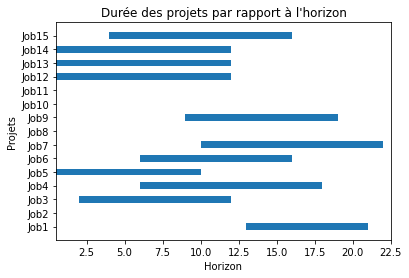

In [57]:
projects_duration = [Realisation[i].x*(End_project[i].x-Begin_project[i].x+1) for i in range(len(data["jobs"]))]
projects_names = [job["name"] for job in data["jobs"]]
starts_dates=[Begin_project[i].x-1 for i in range(len(data["jobs"]))]

plt.barh(projects_names, projects_duration,left= starts_dates, height=0.5)

plt.xlim(0.5, horizon+0.5)
plt.ylabel('Projets')
plt.xlabel('Horizon')
plt.title("Durée des projets par rapport à l'horizon")

plt.show()

In [58]:
res={}
res_V={}
for job in range(projects):
    val=[]
    val_V=[]
    for t in range(horizon):
        for staff in range(staffs):
            for qualif in range(qualifs):
                if(int(Planning[staff][t][job][qualif].x)>0):
                    val.append((t,staff,qualif))
                    val_V.append((t+1,data["staff"][staff]["name"],data['qualifications'][qualif]))
    res[job]=val
    res_V[job+1]=val_V

res_V

{1: [(14, 'Olivia', 'A'),
  (17, 'Emma', 'B'),
  (19, 'Olivia', 'A'),
  (19, 'Emma', 'B'),
  (20, 'Olivia', 'A'),
  (20, 'Emma', 'B'),
  (21, 'Olivia', 'A'),
  (21, 'Emma', 'B')],
 2: [],
 3: [(3, 'Olivia', 'A'),
  (5, 'Olivia', 'C'),
  (10, 'Olivia', 'A'),
  (11, 'Olivia', 'A'),
  (12, 'Olivia', 'A')],
 4: [(8, 'Olivia', 'A'),
  (13, 'Olivia', 'A'),
  (15, 'Olivia', 'A'),
  (16, 'Olivia', 'A'),
  (17, 'Olivia', 'A'),
  (18, 'Olivia', 'A')],
 5: [(2, 'Emma', 'B'),
  (3, 'Liam', 'D'),
  (4, 'Olivia', 'C'),
  (4, 'Liam', 'D'),
  (5, 'Liam', 'D'),
  (6, 'Olivia', 'C'),
  (6, 'Liam', 'D'),
  (7, 'Olivia', 'C'),
  (7, 'Liam', 'D'),
  (7, 'Emma', 'B'),
  (8, 'Liam', 'D'),
  (9, 'Olivia', 'C'),
  (9, 'Liam', 'D'),
  (10, 'Liam', 'D'),
  (10, 'Emma', 'B')],
 6: [(9, 'Amelia', 'E'),
  (11, 'Liam', 'D'),
  (12, 'Liam', 'D'),
  (13, 'Liam', 'E'),
  (13, 'Amelia', 'E'),
  (14, 'Liam', 'E'),
  (14, 'Amelia', 'E'),
  (15, 'Liam', 'D'),
  (16, 'Liam', 'D')],
 7: [(19, 'Liam', 'D'),
  (19, 'Noah', 'D'

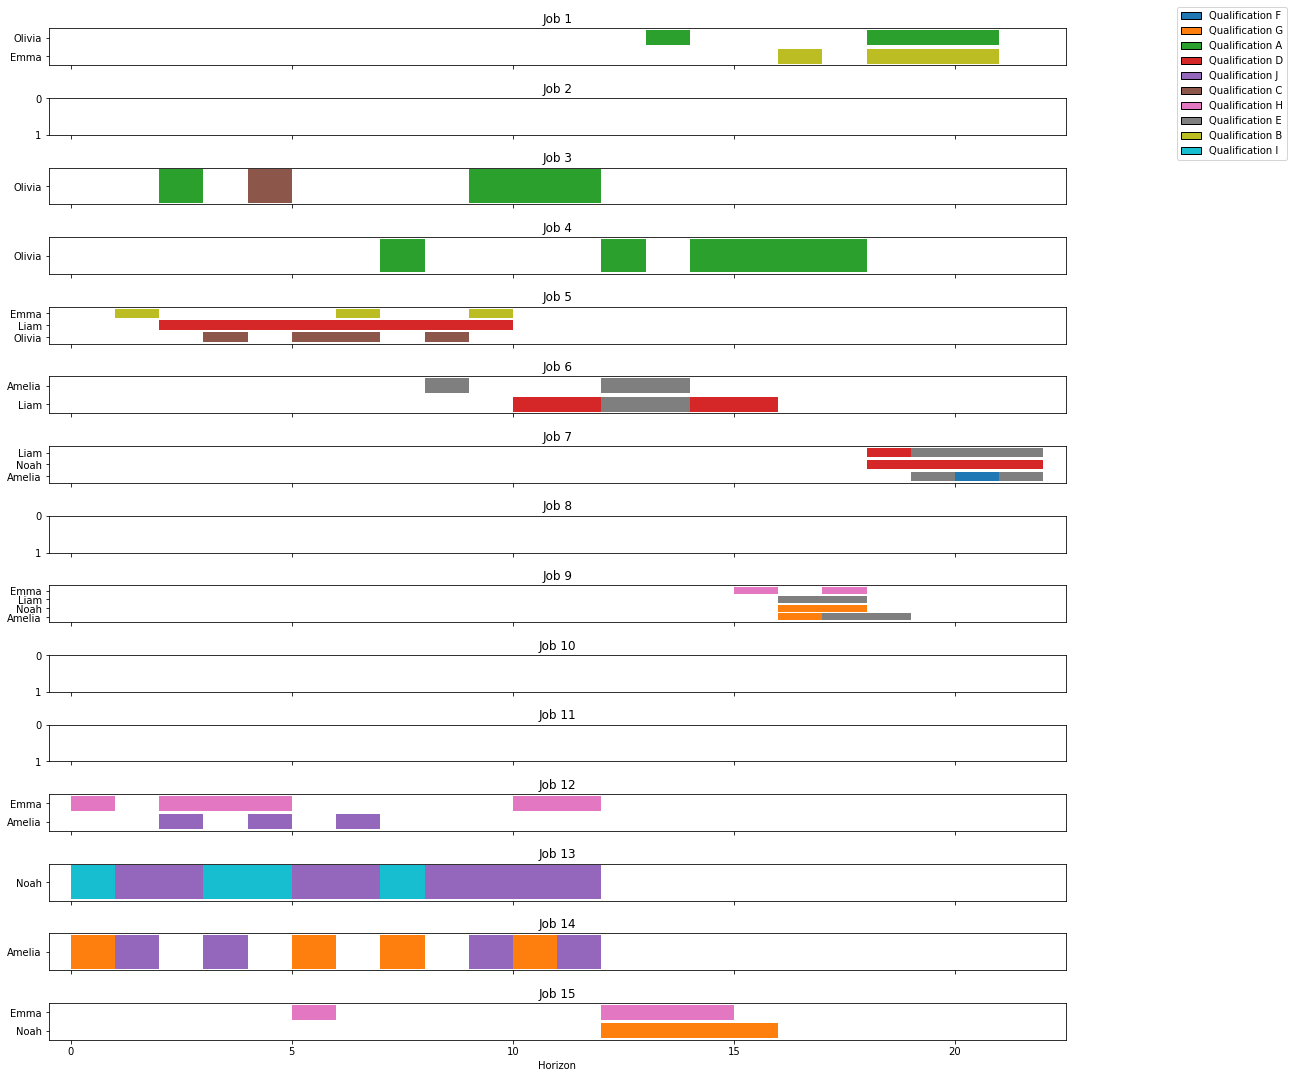

In [66]:
staff_names=[data["staff"][i]["name"] for i in range(staffs)]

fig, axs = plt.subplots(projects, 1, figsize=(15, 15), sharex=True)

color_map = {}
for i in range(qualifs):
    color_map[i]='C'+str(i)

for job, job_data in res.items():
    for day_data in job_data:
        t=day_data[0]
        staff_data=day_data[1]
        qualif_data=day_data[2]
        axs[job].barh(data["staff"][staff_data]["name"], 1, left=t, color=color_map[qualif_data])
    axs[job].set_title(f'Job {job+1}')
    axs[job].invert_yaxis()
    
handles = [plt.Rectangle((0, 0), 1, 1, color=color, ec="k") for color in color_map.values()]
labels = [f"Qualification {data['qualifications'][i]}" for i in color_map.keys()]
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.xlim(-0.5, horizon+0.5)
plt.xlabel("Horizon")
plt.tight_layout()
plt.savefig("Results/jpg/planning_"+path.split("/")[-1].split('.')[0]+".jpg",bbox_inches='tight')
plt.show()


In [61]:
# 4D matrix, Gurobi variables extraction
matrix = np.array([[element.x for element in row] for row in Planning]).reshape(staffs, horizon, projects, qualifs)

# 4D matrix to dataframe
df = pd.DataFrame(np.reshape(matrix, (staffs * horizon, projects * qualifs)),
                  columns=[f"Project {i+1} - Qualification {j+1}" for i in range(projects) for j in range(qualifs)],
                  index=[f"Staff {i+1} - Horizon {j+1}" for i in range(staffs) for j in range(horizon)])

df.loc['sum_row'] = df.sum()

df['sum_column'] = df.sum(axis=1)

df.to_csv("Results/csv/planning_"+path.split("/")[-1].split('.')[0]+".csv",sep=";")
df.to_excel("Results/xlsx/planning_"+path.split("/")[-1].split('.')[0]+".xlsx")


In [62]:
def highlight_cells(val):
    color = 'yellow' if val == 1 else 'red' if val > 1 else ''
    return 'background-color: %s' % color

#df.style.applymap(highlight_cells)

# 8) Explo

In [63]:
sum_assignation=0
moyenne_assignation=0
for staff in range(staffs):
    sum_assignation+=sum_staff_jobs[staff].x

moyenne_assignation=sum_assignation/len(sum_staff_jobs)

print(model.objVal, round(moyenne_assignation,2), Max_duration_lenght.x)

413.0 4.4 12.0


In [64]:
# Save the model to a file
model.write("Results/gurobi_models/model_"+path.split("/")[-1].split('.')[0]+".rlp")

In [65]:
def dominated_p(pareto_points):
    dominated_points = []
    n = len(points)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if all(points[j][k] <= points[i][k] for k in range(3)) and any(points[j][k] < points[i][k] for k in range(3)):
                dominated_points.append(i)
                break
    return [point for i, point in enumerate(points) if i not in dominated_points]
